# This notebook generates csv's of input to be used to run other models (temperature, irradiance, etc)

## Temperature Model Data Generation

In [66]:
%run PVModel_functions.ipynb

In [67]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import datatools
import datetime
import pvlib
import pvanalytics
import math
import pvpltools
import scipy
import sklearn
import statistics

from datetime import datetime
from pvlib import pvsystem
from time import time
from sklearn.metrics import r2_score
from pvpltools import iec61853
from pvpltools.module_efficiency import adr, heydenreich, motherpv, pvgis, mpm5, mpm6, bilinear
from pvpltools.module_efficiency import fit_efficiency_model, fit_bilinear
from pvlib.location import Location
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline 
mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style('whitegrid')

In [189]:
#identify module names and the correct database for met data
mod_names = ['LG', 'Panasonic', 'Can270', 'Can275', 'HanQPlus', 'HanQPeak', 'MissionSolar', 'Jinko']
mettablename = 'dbo.SNLA_Met_DataOut'
#Generate an empty df to store appended results
datagen = []

In [190]:
for mod_name in mod_names:    

    #Reads in an excel file of all necessary module coefficients, string lengths, system dates, etc
    mod_info = pd.read_excel('module_coefficients_bhk.xlsx')
    mod_info.index = mod_info['Manufacturer']
    del mod_info['Manufacturer']
    #defines the specific module given the previous user input and module coefficients file
    module = mod_info[mod_name]
    systablename = module['table_name']
    start = '2021-05-01 00:00:00-07:00'
    end = '2021-05-15 00:00:00-07:00'
#     start = module['start']
#     end = module['end']
    
    # -----------------------------------------------------------------------------------------------------------------
    
    #Import sys & met databases & merge into one df
    df = sys_met_data(mettablename, systablename, start, end)
    
    # -----------------------------------------------------------------------------------------------------------------
    
    #Calculate Solar Positions & Extraterrestrial DNI

    #inputs into this cell: pressure(mBar), time, latitude, longitude, amb temp, altitude
    #outputs of this cell: pressure(Pa), elevation, azimuth, zenith, apparent elevation, apparent zenith, dni extra

    pres = df['Pressure_mBar_Avg']*100
    sdf = pvlib.solarposition.get_solarposition(time=df.index, latitude=module['latitude'], 
            longitude=module['longitude'],temperature=df['Temp_C_Avg'], altitude=module['altitude'])
    sdf['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=df.index)
    
    # -----------------------------------------------------------------------------------------------------------------
    
    #Calculate Environmental Conditions

    #inputs into this cell: module tilt, module azimuth, solar zenith, solar azimuth, DNI, DHI, GHI, DNI extra, 
    #                       transposition model
    #outputs of this cell: poa global, poa direct, poa diffuse, poa sky diffuse, poa ground diffuse

    edf = pvlib.irradiance.get_total_irradiance(surface_tilt=module['tilt'], surface_azimuth=module['surface_azimuth'], 
            solar_zenith=sdf['apparent_zenith'], solar_azimuth=sdf['azimuth'],dni=df['Direct_Wm2_Avg'],
            ghi=df['Global_Wm2_Avg'], dhi=df['Diffuse_Wm2_Avg'], dni_extra=sdf['dni_extra'], model ='haydavies')
    df['poa_global'] = edf['poa_global']
    
    # -----------------------------------------------------------------------------------------------------------------
    

    print('Starting Data Accumulation for ' + mod_name)

    all_rtd = ['LG', 'Panasonic', 'MissionSolar', 'Jinko']
    twth_rtd = ['HanQPlus', 'HanQPeak']
    onfo_rtd = ['Can 270', 'Can275']
    
    if mod_name in all_rtd:
        inputs = df['poa_global'].to_frame()
        inputs['amb_temp'] = df['Temp_C_Avg']
        inputs['wind_speed'] = df['WS_ms_Mean']
        inputs['Mod Temp Str 1'] = df[module['str_1_rtd']]
        inputs['Mod Temp Str 2'] = df[module['str_2_rtd']]
        inputs['Mod Temp Str 3'] = df[module['str_3_rtd']]
        inputs['Mod Temp Str 4'] = df[module['str_4_rtd']]
        inputs['System'] = mod_name
        inputs['Time'] = df.index
        inputs = inputs.loc[~inputs.index.duplicated(), :]

        daterng_all = pd.date_range(start=start, end=end, freq="T")
        inputs = inputs.reindex(daterng_all,method= 'pad')
        datagen.append(inputs)
        
    elif mod_name in twth_rtd:   
        inputs = df['poa_global'].to_frame()
        inputs['amb_temp'] = df['Temp_C_Avg']
        inputs['wind_speed'] = df['WS_ms_Mean']
        inputs['Mod Temp Str 1'] = np.nan
        inputs['Mod Temp Str 2'] = df[module['str_2_rtd']]
        inputs['Mod Temp Str 3'] = df[module['str_3_rtd']]
        inputs['Mod Temp Str 4'] = np.nan
        inputs['System'] = mod_name
        inputs['Time'] = df.index
        inputs = inputs.loc[~inputs.index.duplicated(), :]

        daterng_all = pd.date_range(start=start, end=end, freq="T")
        inputs = inputs.reindex(daterng_all,method= 'pad')
        datagen.append(inputs)
        
    else:    
        inputs = df['poa_global'].to_frame()
        inputs['amb_temp'] = df['Temp_C_Avg']
        inputs['wind_speed'] = df['WS_ms_Mean']
        inputs['Mod Temp Str 1'] = df[module['str_1_rtd']]
        inputs['Mod Temp Str 2'] = np.nan
        inputs['Mod Temp Str 3'] = np.nan
        inputs['Mod Temp Str 4'] = df[module['str_4_rtd']]
        inputs['System'] = mod_name
        inputs['Time'] = df.index
        inputs = inputs.loc[~inputs.index.duplicated(), :]

        daterng_all = pd.date_range(start=start, end=end, freq="T")
        inputs = inputs.reindex(daterng_all,method= 'pad')
        datagen.append(inputs)
        
    # -----------------------------------------------------------------------------------------------------------------

        
    print('Done with ' + mod_name)

Starting Data Accumulation for LG
Done with LG
Starting Data Accumulation for Panasonic
Done with Panasonic
Starting Data Accumulation for Can270
Done with Can270
Starting Data Accumulation for Can275
Done with Can275
Starting Data Accumulation for HanQPlus
Done with HanQPlus
Starting Data Accumulation for HanQPeak
Done with HanQPeak
Starting Data Accumulation for MissionSolar
Done with MissionSolar
Starting Data Accumulation for Jinko
Done with Jinko


In [191]:
datagen_df = pd.concat(datagen, ignore_index=True)
datagen_df.index = datagen_df.Time
datagen_df.to_csv('temp_inputs_052021.csv')

# create a file that has all measured temperature data horizontally

In [192]:
inputs = df['poa_global'].to_frame()
inputs['amb_temp'] = df['Temp_C_Avg']
inputs['wind_speed'] = df['WS_ms_Mean']

for mod_name in mod_names:    

    #Reads in an excel file of all necessary module coefficients, string lengths, system dates, etc
    mod_info = pd.read_excel('module_coefficients_bhk.xlsx')
    mod_info.index = mod_info['Manufacturer']
    del mod_info['Manufacturer']
    #defines the specific module given the previous user input and module coefficients file
    module = mod_info[mod_name]
    systablename = module['table_name']
    start = start
    end = end
#     start = module['start']
#     end = module['end']
    
    # -----------------------------------------------------------------------------------------------------------------
    
    #Import sys & met databases & merge into one df
    df = sys_met_data(mettablename, systablename, start, end)
    
    # -----------------------------------------------------------------------------------------------------------------
    
    #Calculate Solar Positions & Extraterrestrial DNI

    #inputs into this cell: pressure(mBar), time, latitude, longitude, amb temp, altitude
    #outputs of this cell: pressure(Pa), elevation, azimuth, zenith, apparent elevation, apparent zenith, dni extra

    pres = df['Pressure_mBar_Avg']*100
    sdf = pvlib.solarposition.get_solarposition(time=df.index, latitude=module['latitude'], 
            longitude=module['longitude'],temperature=df['Temp_C_Avg'], altitude=module['altitude'])
    sdf['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=df.index)
    
    # -----------------------------------------------------------------------------------------------------------------
    
    #Calculate Environmental Conditions

    #inputs into this cell: module tilt, module azimuth, solar zenith, solar azimuth, DNI, DHI, GHI, DNI extra, 
    #                       transposition model
    #outputs of this cell: poa global, poa direct, poa diffuse, poa sky diffuse, poa ground diffuse

    edf = pvlib.irradiance.get_total_irradiance(surface_tilt=module['tilt'], surface_azimuth=module['surface_azimuth'], 
            solar_zenith=sdf['apparent_zenith'], solar_azimuth=sdf['azimuth'],dni=df['Direct_Wm2_Avg'],
            ghi=df['Global_Wm2_Avg'], dhi=df['Diffuse_Wm2_Avg'], dni_extra=sdf['dni_extra'], model ='haydavies')
    df['poa_global'] = edf['poa_global']
    
    # -----------------------------------------------------------------------------------------------------------------

    print('Starting Data Accumulation for ' + mod_name)

    all_rtd = ['LG', 'Panasonic', 'MissionSolar', 'Jinko']
    twth_rtd = ['HanQPlus', 'HanQPeak']
    onfo_rtd = ['Can 270', 'Can275']
    
    if mod_name in all_rtd:
        inputs[mod_name + 'Mod Temp Str 1'] = df[module['str_1_rtd']]
        inputs[mod_name + 'Mod Temp Str 2'] = df[module['str_2_rtd']]
        inputs[mod_name + 'Mod Temp Str 3'] = df[module['str_3_rtd']]
        inputs[mod_name + 'Mod Temp Str 4'] = df[module['str_4_rtd']]
        
        inputs = inputs.loc[~inputs.index.duplicated(), :]

        daterng_all = pd.date_range(start=start, end=end, freq="T")
        inputs = inputs.reindex(daterng_all,method= 'pad')
        
    elif mod_name in twth_rtd:   
        
        inputs[mod_name + 'Mod Temp Str 2'] = df[module['str_2_rtd']]
        inputs[mod_name + 'Mod Temp Str 3'] = df[module['str_3_rtd']]


        inputs = inputs.loc[~inputs.index.duplicated(), :]

        daterng_all = pd.date_range(start=start, end=end, freq="T")
        inputs = inputs.reindex(daterng_all,method= 'pad')
     
        
    else:    

        inputs[mod_name +'Mod Temp Str 1'] = df[module['str_1_rtd']]
        inputs[mod_name +'Mod Temp Str 4'] = df[module['str_4_rtd']]

        inputs = inputs.loc[~inputs.index.duplicated(), :]

        daterng_all = pd.date_range(start=start, end=end, freq="T")
        inputs = inputs.reindex(daterng_all,method= 'pad')
        
    # -----------------------------------------------------------------------------------------------------------------

        
    print('Done with ' + mod_name)

Starting Data Accumulation for LG
Done with LG
Starting Data Accumulation for Panasonic
Done with Panasonic
Starting Data Accumulation for Can270
Done with Can270
Starting Data Accumulation for Can275
Done with Can275
Starting Data Accumulation for HanQPlus
Done with HanQPlus
Starting Data Accumulation for HanQPeak
Done with HanQPeak
Starting Data Accumulation for MissionSolar
Done with MissionSolar
Starting Data Accumulation for Jinko
Done with Jinko


In [193]:
inputs.drop(columns=['poa_global', 'amb_temp','wind_speed'], inplace=True)

In [194]:
inputs.to_csv('modstrtemp_052021.csv')

# Irradiance Models Data Generation

In [186]:
df = sys_met_data(mettablename= 'dbo.SNLA_Met_DataOut', systablename='PVLT_Can_Han_Canadian_Hanwha',
                            start = '2021-05-01 00:00:00-07:00', end = '2021-05-15 00:00:00-07:00')
sdf = pvlib.solarposition.get_solarposition(time=df.index, latitude=module['latitude'], 
            longitude=module['longitude'],temperature=df['Temp_C_Avg'], altitude=module['altitude'])

<IPython.core.display.Javascript object>


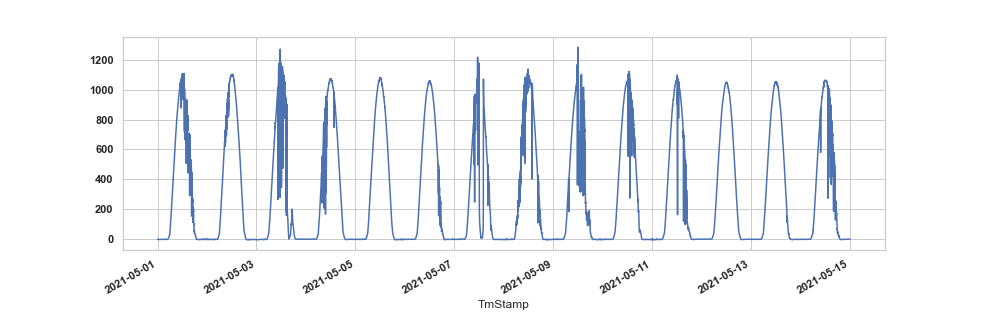

<AxesSubplot:xlabel='TmStamp'>

In [187]:
#check that data is available and see what the conditions of the time period look like
%matplotlib notebook
df['BroadbandPOA_Avg'].plot()

In [188]:
inputs = df['Global_Wm2_Avg'].to_frame()
inputs.rename(columns = {'Global_Wm2_Avg' : 'GHI'}, inplace = True)
inputs['DNI'] = df['Direct_Wm2_Avg']
inputs['DHI'] = df['Diffuse_Wm2_Avg']
inputs['DNI_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=df.index)
inputs['amb_temp'] = df['Temp_C_Avg']
inputs['sol_azi'] = sdf['azimuth']
inputs['sol_zen'] = sdf['apparent_zenith']
inputs['albedo'] = df['Albedo_Avg']
inputs['Measured POA'] = df['BroadbandPOA_Avg']
inputs['airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=sdf['apparent_zenith'])
inputs['Solar Elevation'] = sdf['apparent_elevation']
inputs = simple_filter(sys=inputs, variable='Solar Elevation', lower=5, upper=90, apply=True)
inputs.to_csv('irr_inputs_112021.csv')